In [33]:
import warnings
import keplergl
import numpy as np
import osmnx as ox
import pandas as pd
import geopandas as gpd
import plotly.express as px
from skgstat import Variogram
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pykrige.ok import OrdinaryKriging
from scipy.interpolate import NearestNDInterpolator
from tobler.area_weighted import area_interpolate
import plotly.express as px
import json
import ogr
import ipywidgets as widgets
from IPython.display import display
# Custom functions
from scripts.utils import pixel2poly
# Plotting defaults
plt.style.use('ggplot')
px.defaults.height = 400; px.defaults.width = 620
plt.rcParams.update({'font.size': 16, 'axes.labelweight': 'bold', 'figure.figsize': (6, 6), 'axes.grid': False})

In [34]:
# this isn't really a .geojson, it's just a json list of features
with open('van_poly.geojson') as f:
  blocks = json.load(f)

In [35]:
# we need to convert it to geojson format by putting back in this dictionary structure
geo_json = {"type": "FeatureCollection", "features": blocks}
geo_json["features"][0]

{'type': 'Feature',
 'properties': {'DBUID': '59150244005',
  'DBRPLAMX': 4030983.593945,
  'DBRPLAMY': 2005717.42964501,
  'PRUID': '59',
  'PRNAME': 'British Columbia / Colombie-Britannique',
  'CDUID': '5915',
  'CDNAME': 'Greater Vancouver',
  'CDTYPE': 'RD',
  'CCSUID': '5915020',
  'CCSNAME': 'Greater Vancouver A',
  'CSDUID': '5915046',
  'CSDNAME': 'North Vancouver',
  'CSDTYPE': 'DM',
  'ERUID': '5920',
  'ERNAME': 'Lower Mainland--Southwest / Lower Mainland--Sud-ouest',
  'FEDUID': '59002',
  'FEDNAME': 'Burnaby North--Seymour / Burnaby-Nord--Seymour',
  'SACCODE': '933',
  'SACTYPE': '1',
  'CMAUID': '933',
  'CMAPUID': '59933',
  'CMANAME': 'Vancouver',
  'CMATYPE': 'B',
  'CTUID': '9330110.03',
  'CTNAME': '0110.03',
  'ADAUID': '59150014',
  'DAUID': '59150244'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-122.96251616532064, 49.32169736741242],
    [-122.96222837991496, 49.321261359289615],
    [-122.9621961748921, 49.32116586646329],
    [-122.96234696135333, 

In [36]:
df = gpd.GeoDataFrame.from_features(geo_json)
df = df[['geometry', 'DBUID']]
df.head()

,geometry,DBUID
0,"POLYGON ((-122.96252 49.32170, -122.96223 49.3...",59150244005
1,"POLYGON ((-122.96832 49.34238, -122.96780 49.3...",59150244008
2,"POLYGON ((-123.07798 49.25263, -123.07799 49.2...",59150372006
3,"POLYGON ((-123.07991 49.25206, -123.07802 49.2...",59150372007
4,"POLYGON ((-123.08188 49.25090, -123.08189 49.2...",59150373001


In [12]:
van_api = (ox.geometries_from_place('Vancouver, Canada', tags={'building':True})
         .loc[:, ["geometry"]]                 # just keep the geometry column for now
         .query("geometry.type == 'Polygon'")  # only what polygons (buidling footprints)
         .assign(Label="Building Footprints")  # assign a label for later use
         .reset_index(drop=True)               # reset to 0 integer indexing
      )
van_api.head()

,geometry,Label
0,"POLYGON ((-123.07270 49.21479, -123.07365 49.2...",Building Footprints
1,"POLYGON ((-123.11352 49.27631, -123.11329 49.2...",Building Footprints
2,"POLYGON ((-123.10901 49.27844, -123.10881 49.2...",Building Footprints
3,"POLYGON ((-123.13516 49.27260, -123.13519 49.2...",Building Footprints
4,"POLYGON ((-123.09811 49.27417, -123.09808 49.2...",Building Footprints


C:\Users\rainy\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


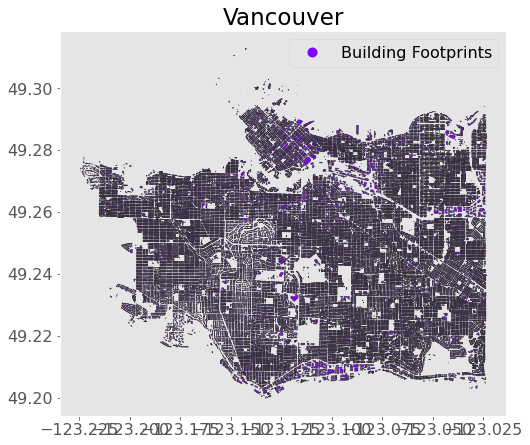

In [15]:
ax = van.plot(figsize=(8, 8), column="Label", legend=True,
              edgecolor="0.2", markersize=200, cmap="rainbow")
plt.title("Vancouver");

## Kepler.gl

### Geojson

In [8]:
import keplergl
map_1 = keplergl.KeplerGl(height=600)
map_1.add_data(geo_json, "geojson")
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'geojson': {'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'DBUID…

In [10]:
import keplergl
van_map = keplergl.KeplerGl(height=500)
van_map.add_data(data=van.copy(), name="Building heights")
van_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Building heights': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18…

In [6]:
map_1.save_to_html(file_name='json.html')

Map saved to json.html!


In [7]:
%%html
<iframe src="json.html" width="80%" height="500"></iframe>

### All destinations

In [9]:
des = pd.read_csv('all_destination_scores.csv')
des.loc[des['fromId'] == 59154027001,'score']

14227    0.113493
Name: score, dtype: float64

In [10]:
ttm = pd.read_csv('ttm_1.5.csv')
ttm.query('fromId==59154027001')['toId']
# ttm.loc[ttm['fromId'] == 59154027001, 'toId']

5368060     115
5368061    2359
5368062    7212
Name: toId, dtype: int64

In [11]:
ttm.head()

,fromId,toId,avg_unique_time,sd_unique_time
0,59150004004,10,97.641026,3.936918
1,59150004004,15,72.487179,3.401794
2,59150004004,157,96.692308,3.001349
3,59150004004,1759,106.820513,4.388213
4,59150004004,1760,46.589744,2.642944


### Read shapefiles for Dissemination Blocks

In [10]:
van = gpd.read_file("ldb_000b16a_e", rows = slice(430905, 431004))

In [35]:
van = gpd.read_file("ldb_000b16a_e", bbox=(-123.45,48.99,-122.45,49.49))

In [6]:
ca = gpd.read_file("ldb_000b16a_e")
bc = ca[ca['PRNAME'] == 'British Columbia / Colombie-Britannique']
van = bc[bc['CMANAME'] == 'Vancouver']
# van = van.reset_index(drop=True)
van = van[['DBUID', 'geometry']]
van

,DBUID,geometry
430905,59150244005,"POLYGON ((4031012.989 2005749.389, 4031008.691..."
430906,59150244008,"POLYGON ((4031720.003 2007975.080, 4031753.591..."
430907,59150372006,"POLYGON ((4019999.297 2002926.017, 4019976.249..."
430908,59150372007,"POLYGON ((4019845.486 2002936.617, 4019919.283..."
430909,59150373001,"POLYGON ((4019657.589 2002889.880, 4019631.389..."
...,...,...
482214,59153521001,"POLYGON ((4030892.540 1982172.203, 4030755.003..."
482215,59153521002,"POLYGON ((4030570.246 1982459.846, 4030646.403..."
482216,59153521003,"POLYGON ((4030728.943 1982566.280, 4030822.440..."
482217,59153521004,"POLYGON ((4030523.351 1982365.306, 4030456.617..."


In [3]:
van.to_csv('van_kep.csv', index=False)

In [33]:
type(van)

geopandas.geodataframe.GeoDataFrame

In [5]:
from geopandas import GeoDataFrame
van = van.reset_index(drop=True)
van = van.set_crs(crs="EPSG:3857", allow_override=True)
#van = GeoDataFrame(van, crs="EPSG:3857")
# van = van.to_crs("EPSG:3857")

In [39]:
van = van[van['CMANAME'] == 'Vancouver']

In [40]:
# van = pd.DataFrame(van)
van.count()

DBUID       15196
DBRPLAMX    15196
DBRPLAMY    15196
PRUID       15196
PRNAME      15196
CDUID       15196
CDNAME      15196
CDTYPE      15196
CCSUID      15196
CCSNAME     15196
CSDUID      15196
CSDNAME     15196
CSDTYPE     15196
ERUID       15196
ERNAME      15196
FEDUID      15196
FEDNAME     15196
SACCODE     15196
SACTYPE     15196
CMAUID      15196
CMAPUID     15196
CMANAME     15196
CMATYPE     15196
CTUID       15196
CTNAME      15196
ADAUID      15196
DAUID       15196
geometry    15196
dtype: int64

In [39]:
# id needs to be numeric for joining

df["DBUID"] = pd.to_numeric(df["DBUID"])

In [13]:
scores = pd.read_csv('all_destination_scores.csv')
scores.columns = ['DBUID', 'Score']
scores.head()

,DBUID,Score
0,59150004004,0.409541
1,59150004005,0.404883
2,59150004006,0.404903
3,59150004011,0.406174
4,59150004012,0.403910


### Merge two data sets

In [14]:
van_geo = df.merge(scores, on='DBUID')
van_geo.head()

,geometry,DBUID,Score
0,"POLYGON ((-122.96252 49.32170, -122.96223 49.3...",59150244005,0.312841
1,"POLYGON ((-123.07798 49.25263, -123.07799 49.2...",59150372006,0.710115
2,"POLYGON ((-123.07991 49.25206, -123.07802 49.2...",59150372007,0.710409
3,"POLYGON ((-123.08188 49.25090, -123.08189 49.2...",59150373001,0.707403
4,"POLYGON ((-123.08268 49.24857, -123.08332 49.2...",59150373002,0.707778


In [9]:
# kep = pd.merge(van, scores.rename(columns={'fromId':'DBUID'}), on='DBUID',  how='left')
kep = pd.merge(van, scores, left_on='DBUID', right_on='fromId', how='left').drop('fromId', axis=1)
kep.head()

,DBUID,geometry,score
0,59150244005,"POLYGON ((4031012.989 2005749.389, 4031008.691...",0.312841
1,59150244008,"POLYGON ((4031720.003 2007975.080, 4031753.591...",NaN
2,59150372006,"POLYGON ((4019999.297 2002926.017, 4019976.249...",0.710115
3,59150372007,"POLYGON ((4019845.486 2002936.617, 4019919.283...",0.710409
4,59150373001,"POLYGON ((4019657.589 2002889.880, 4019631.389...",0.707403


In [67]:
kep = kep[['DBUID', 'score', 'geometry']]
kep.head()

,DBUID,score,geometry
0,59150244005,0.312841,POLYGON ((4031012.9885700000450015 2005749.388...
1,59150244008,NaN,POLYGON ((4031720.0028550000861287 2007975.080...
2,59150372006,0.710115,POLYGON ((4019999.2971449997276068 2002926.017...
3,59150372007,0.710409,POLYGON ((4019845.4857149999588728 2002936.617...
4,59150373001,0.707403,POLYGON ((4019657.5885700001381338 2002889.879...


In [ ]:
together = (gpd.sjoin(van, gdf, how="left")
                       .drop(columns="index_right")
#                        .rename(columns={"hgt_agl": "Height"})
                       .reset_index()
                       .dissolve(by="index", aggfunc="mean")  # dissolve is like "groupby" in pandas. We use it because it retains geometry information
                   )

## Compute kepler map

### For all destinations

In [15]:
van_kep = keplergl.KeplerGl(height=500)
van_kep.add_data(data=van_geo.copy(), name="DB Scores")
van_kep

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'DB Scores': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2…

In [10]:
van_kep.save_to_html(file_name='Vancouver_Kepler.html')

Map saved to Vancouver_Kepler.html!


In [39]:
%%html
<iframe src="Vancouver_Kepler.html" width="80%" height="500"></iframe>

### Nearest library

In [16]:
library1 = pd.read_csv('nearest1_library_or_archives_scores.csv')
library1.columns = ['DBUID', 'Score']
library1.head()

,DBUID,Score
0,59150004004,0.217863
1,59150004005,0.217357
2,59150004006,0.213091
3,59150004011,0.213930
4,59150004012,0.208508


In [17]:
van_lib1 = df.merge(library1, on='DBUID')
van_lib1.head()

,geometry,DBUID,Score
0,"POLYGON ((-122.96252 49.32170, -122.96223 49.3...",59150244005,0.485169
1,"POLYGON ((-123.07798 49.25263, -123.07799 49.2...",59150372006,0.585612
2,"POLYGON ((-123.07991 49.25206, -123.07802 49.2...",59150372007,0.620586
3,"POLYGON ((-123.08188 49.25090, -123.08189 49.2...",59150373001,0.516520
4,"POLYGON ((-123.08268 49.24857, -123.08332 49.2...",59150373002,0.535664


In [18]:
lib1 = keplergl.KeplerGl(height=500)
lib1.add_data(data=van_lib1.copy(), name="DB Scores")
lib1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'DB Scores': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2…

In [19]:
lib1.save_to_html(file_name='Lib1_Kepler.html')

Map saved to Lib1_Kepler.html!


### Nearest Museum

In [20]:
museum1 = pd.read_csv('nearest1_museum_scores.csv')
museum1.columns = ['DBUID', 'Score']
museum1.head()

,DBUID,Score
0,59150004004,0.240111
1,59150004005,0.231695
2,59150004006,0.227944
3,59150004011,0.236166
4,59150004012,0.233876


In [21]:
van_muse1 = df.merge(museum1, on='DBUID')
van_muse1.head()

,geometry,DBUID,Score
0,"POLYGON ((-122.96252 49.32170, -122.96223 49.3...",59150244005,0.134515
1,"POLYGON ((-123.07798 49.25263, -123.07799 49.2...",59150372006,0.377272
2,"POLYGON ((-123.07991 49.25206, -123.07802 49.2...",59150372007,0.376623
3,"POLYGON ((-123.08188 49.25090, -123.08189 49.2...",59150373001,0.364482
4,"POLYGON ((-123.08268 49.24857, -123.08332 49.2...",59150373002,0.320572


In [22]:
muse1 = keplergl.KeplerGl(height=500)
muse1.add_data(data=van_muse1.copy(), name="DB Scores")
muse1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'DB Scores': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2…

In [23]:
muse1.save_to_html(file_name='Muse1_Kepler.html')

Map saved to Muse1_Kepler.html!


### Nearest Gallery

In [24]:
gallery1 = pd.read_csv('nearest1_gallery_scores.csv')
gallery1.columns = ['DBUID', 'Score']
gallery1.head()

,DBUID,Score
0,59150004004,0.231266
1,59150004005,0.232063
2,59150004006,0.231326
3,59150004011,0.228734
4,59150004012,0.227863


In [25]:
van_gal1 = df.merge(gallery1, on='DBUID')
van_gal1.head()

,geometry,DBUID,Score
0,"POLYGON ((-122.96252 49.32170, -122.96223 49.3...",59150244005,0.193400
1,"POLYGON ((-123.07798 49.25263, -123.07799 49.2...",59150372006,0.364944
2,"POLYGON ((-123.07991 49.25206, -123.07802 49.2...",59150372007,0.363815
3,"POLYGON ((-123.08188 49.25090, -123.08189 49.2...",59150373001,0.373992
4,"POLYGON ((-123.08268 49.24857, -123.08332 49.2...",59150373002,0.401834


In [26]:
gal1 = keplergl.KeplerGl(height=500)
gal1.add_data(data=van_gal1.copy(), name="DB Scores")
gal1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'DB Scores': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2…

In [27]:
gal1.save_to_html(file_name='Gal1_Kepler.html')

Map saved to Gal1_Kepler.html!


### All amenities in different types

In [37]:
types = pd.read_csv('type_destination_scores.csv')
# types.columns = ['DBUID', 'Score']
types.head()

,fromId,score,type
0,59150004004,0.020862,art or cultural centre
1,59150004004,0.115708,artist
2,59150004004,0.317420,gallery
3,59150004004,0.032337,heritage or historic site
4,59150004004,0.182327,library or archives


In [40]:
van_gal1 = df.merge(gallery1, on='DBUID')
van_gal1.head()

,geometry,DBUID,Score
0,"POLYGON ((-122.96252 49.32170, -122.96223 49.3...",59150244005,0.193400
1,"POLYGON ((-123.07798 49.25263, -123.07799 49.2...",59150372006,0.364944
2,"POLYGON ((-123.07991 49.25206, -123.07802 49.2...",59150372007,0.363815
3,"POLYGON ((-123.08188 49.25090, -123.08189 49.2...",59150373001,0.373992
4,"POLYGON ((-123.08268 49.24857, -123.08332 49.2...",59150373002,0.401834


In [ ]:
gal1 = keplergl.KeplerGl(height=500)
gal1.add_data(data=van_gal1.copy(), name="DB Scores")
gal1

In [ ]:
gal1.save_to_html(file_name='Gal1_Kepler.html')